# **Preparation**

Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Connecting to Kaggle

In [ ]:
!mkdir ~/.kaggle

!pip install kaggle

# copying api file
!cp drive/MyDrive/kaggle.json ~/.kaggle/
# modding permission
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading Garbage Classification Image Dataset from Kaggle

In [ ]:
# downloading data using api command from the site
!kaggle datasets download -d mostafaabla/garbage-classification
# unzip the downloaded file
!unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

Installing Libraries

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import random
import os
from pathlib import Path
import cv2
import splitfolders
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten, MaxPooling3D

          class  count
0       plastic    865
1   white-glass    775
2         metal    769
3       battery    945
4         trash    697
5   green-glass    629
6    biological    985
7     cardboard    891
8   brown-glass    607
9       clothes   5325
10        paper   1050
11        shoes   1977


<AxesSubplot:xlabel='class', ylabel='count'>

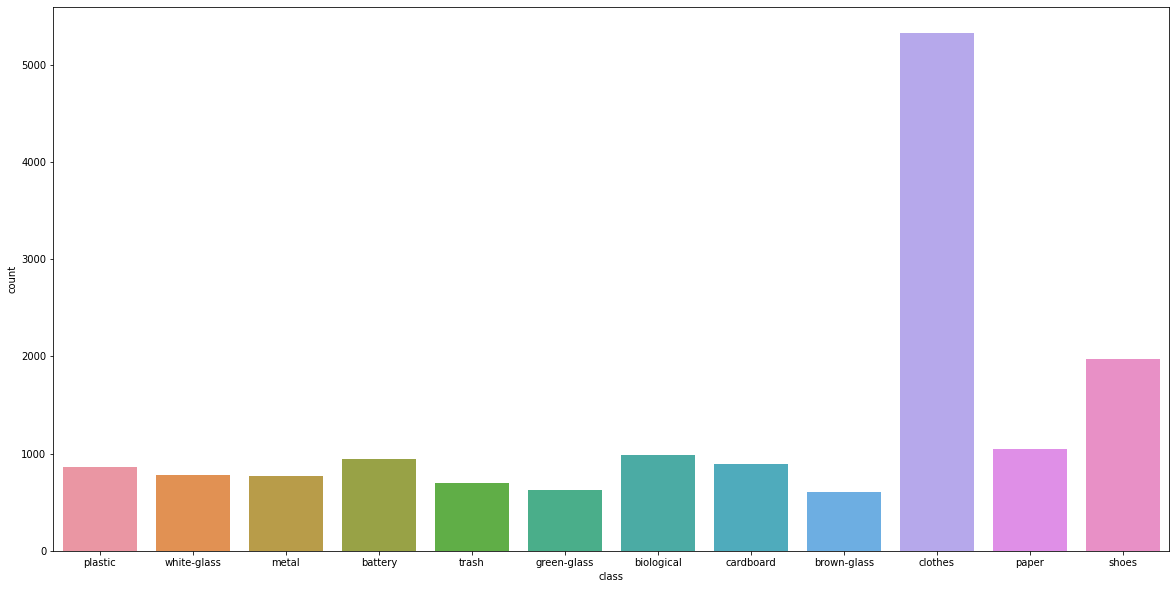

In [ ]:
img_data = {}

for folder in os.listdir("garbage_classification/"):
    img_data[folder] = len(os.listdir("garbage_classification/"+folder))

image_data = pd.DataFrame(list(img_data.items()), index=range(0,len(img_data)), columns=['class','count'])

print(image_data)

plt.figure(figsize=(20,10))
sns.barplot(x='class',y='count',data=image_data)

          class  count
0       plastic    865
1   white-glass    775
2         metal    769
3       battery    945
4         trash    697
5   green-glass    629
6    biological    985
7     cardboard    891
8   brown-glass    607
9       clothes   1025
10        paper   1050
11        shoes    977


<AxesSubplot:xlabel='class', ylabel='count'>

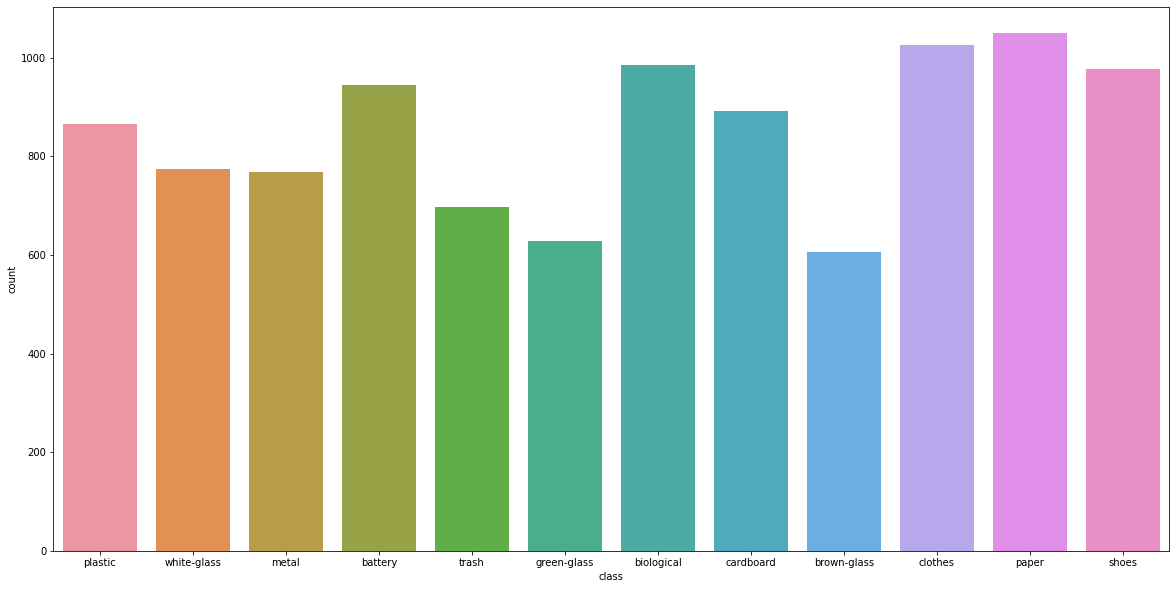

In [ ]:
# Karena terdapat kelebihan data signifikan pada class 'clothes' dan 'shoes', maka sebelum splitting, data akan diberlakukan random undersampling

# delete 4300 gambar random dari class 'clothes'

path = r'garbage_classification/clothes/'
n = 4300
img_names = os.listdir(path)  
img_names = random.sample(img_names, n)
for image in img_names:
  f = os.path.join(path, image)
  os.remove(f)

# delete 1000 gambar random dari class 'clothes'

path = r'garbage_classification/shoes/'
n = 1000
img_names = os.listdir(path)  
img_names = random.sample(img_names, n)
for image in img_names:
  f = os.path.join(path, image)
  os.remove(f)

img_data = {}

for folder in os.listdir("garbage_classification/"):
    img_data[folder] = len(os.listdir("garbage_classification/"+folder))

image_data = pd.DataFrame(list(img_data.items()), index=range(0,len(img_data)), columns=['class','count'])

print(image_data)

plt.figure(figsize=(20,10))
sns.barplot(x='class',y='count',data=image_data)

Splitting Dataset into Train, Test, and Validation Folders

In [ ]:
splitfolders.ratio("garbage_classification", output="data", seed="4761", ratio=(0.7,0.1,0.2))

Copying files: 10215 files [00:01, 7729.89 files/s]


In [ ]:
# import shutil
# shutil.rmtree("data")

Number of images in the val set : 1015 images
Number of images in the train set : 7144 images
Number of images in the test set : 2056 images

          class  count
0       plastic    605
1   white-glass    542
2         metal    538
3       battery    661
4         trash    487
5   green-glass    440
6    biological    689
7     cardboard    623
8   brown-glass    424
9       clothes    717
10        paper    735
11        shoes    683

          class  count
0       plastic    174
1   white-glass    156
2         metal    155
3       battery    190
4         trash    141
5   green-glass    127
6    biological    198
7     cardboard    179
8   brown-glass    123
9       clothes    206
10        paper    210
11        shoes    197



<AxesSubplot:xlabel='class', ylabel='count'>

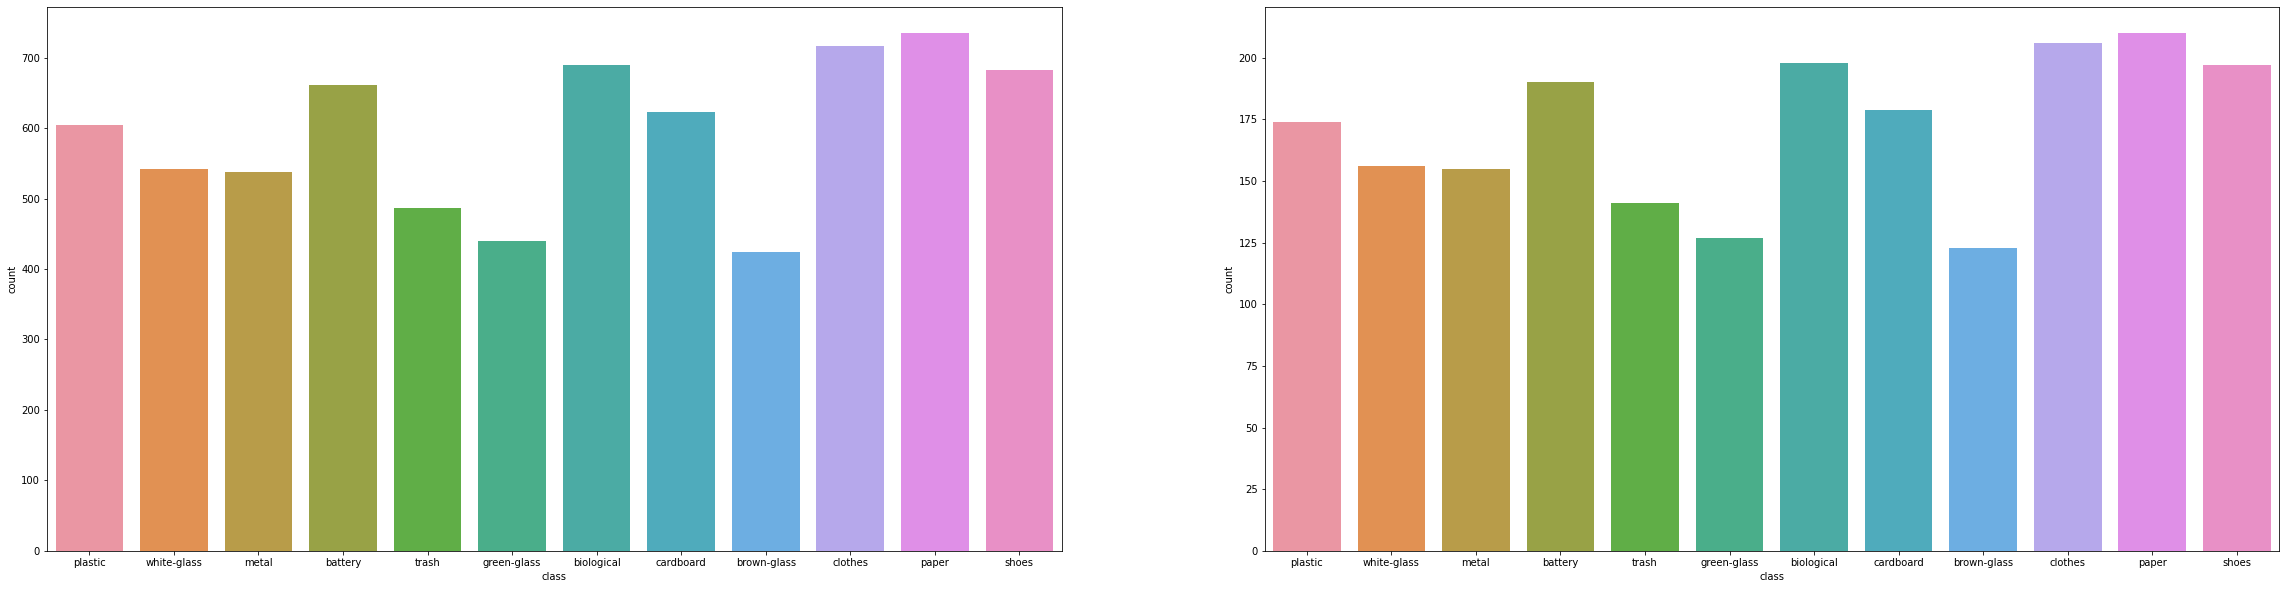

In [ ]:
data_folders = os.listdir("data")

for folder in data_folders:
  path = Path('data/' + folder)
  number_of_files = sum(1 for x in path.glob('**/*') if x.is_file())
  print(f"Number of images in the {folder} set : {number_of_files} images")

train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

quantity_tr = {}
quantity_te = {}

for folder in os.listdir(train_dir):
    quantity_tr[folder] = len(os.listdir(train_dir+folder))

for folder in os.listdir(test_dir):
    quantity_te[folder] = len(os.listdir(test_dir+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

print()

print(quantity_train)
print()
print(quantity_test)
print()

figure, ax = plt.subplots(1,2,figsize=(40,10))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(val_dir)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(val_dir)):
        image_ids = os.listdir(os.path.join(val_dir,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(val_dir,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                display_resized = cv2.resize(display,(150,150))
                display_normalized = display_resized/255
                predicted_classname = inv_map_classes[np.argmax(mobilenetv2_best_model.predict(np.array([display_normalized])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

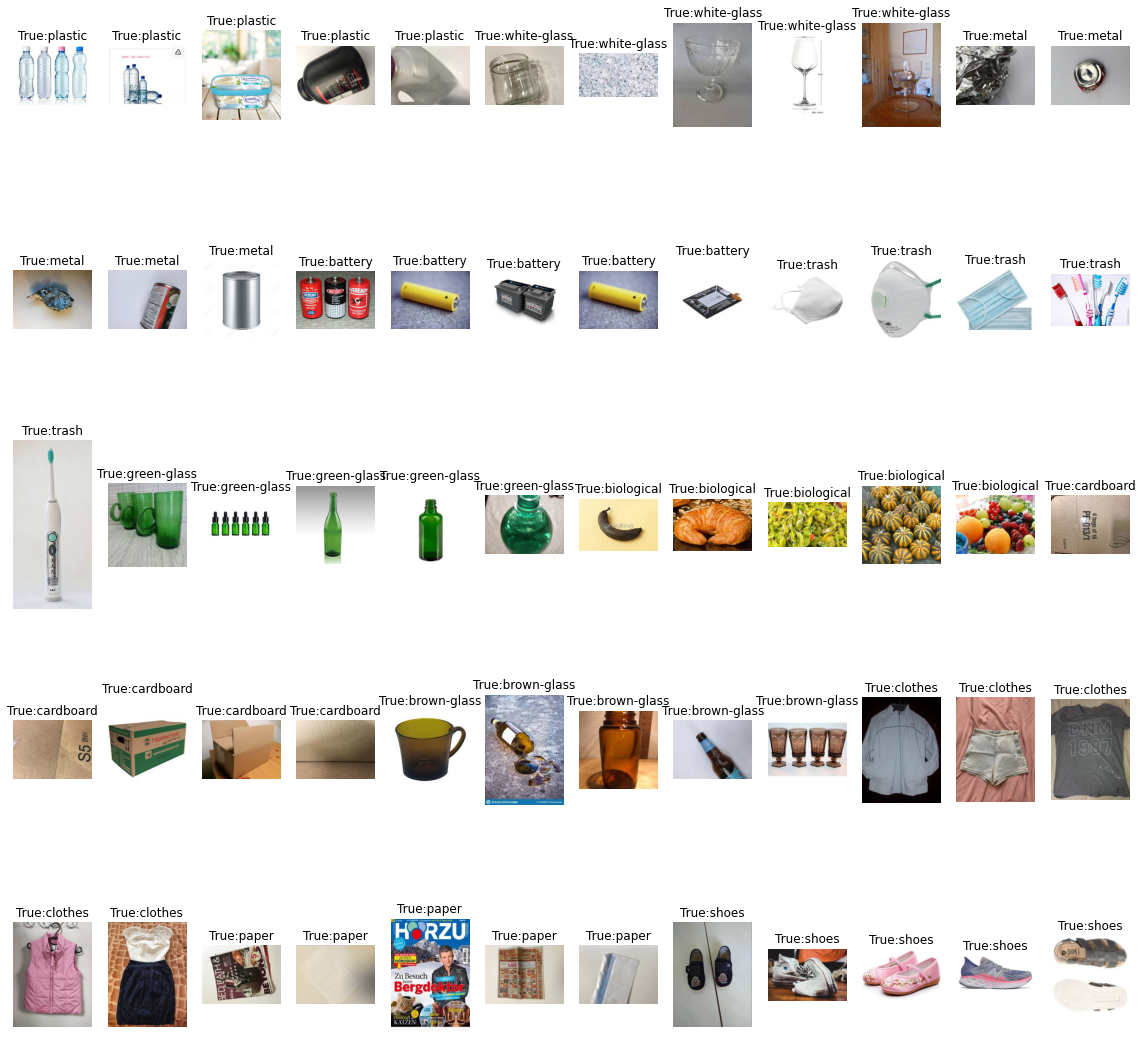

In [ ]:
show_few_images(5)

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_dir, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 7144 images belonging to 12 classes.
Found 2056 images belonging to 12 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}
{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [ ]:
tf.keras.backend.clear_session()

# epoch config
mobilenetv2_epoch = 60

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


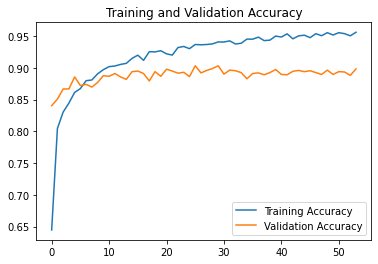

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


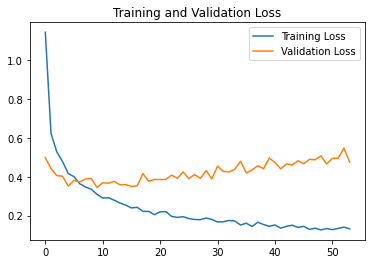

<Figure size 432x288 with 0 Axes>

In [ ]:
mobilenetv2_model = MobileNetV2(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in mobilenetv2_model.layers:
  layers.trainable=False

last_output = mobilenetv2_model.layers[-1].output
mobilenetv2_x = Flatten()(last_output)
mobilenetv2_x = Dense(128, activation = 'relu')(mobilenetv2_x)
mobilenetv2_x = Dropout(0.5)(mobilenetv2_x)
mobilenetv2_x = Dense(12, activation = 'softmax')(mobilenetv2_x)
mobilenetv2_final_model = Model(mobilenetv2_model.input, mobilenetv2_x)
mobilenetv2_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

mobilenetv2_final_model.summary()

# MobileNetV2
number_of_epochs = mobilenetv2_epoch
mobilenetv2_filepath = 'mobilenetv2_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
mobilenetv2_checkpoint = tf.keras.callbacks.ModelCheckpoint(mobilenetv2_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
mobilenetv2_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
mobilenetv2_history = mobilenetv2_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator, callbacks=[mobilenetv2_checkpoint,mobilenetv2_early_stopping],verbose=1)

do_history_stuff(mobilenetv2_history, 'mobilenetv2_model')

In [ ]:
mobilenetv2_best_model = mobilenetv2_final_model

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
mobilenetv2_pred = []

for folder in os.listdir(val_dir):
    
    test_image_ids = os.listdir(os.path.join(val_dir,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(val_dir,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255

        mobilenetv2_image_prediction = np.argmax(mobilenetv2_best_model.predict(np.array([img_normalized])))
        mobilenetv2_pred.append(mobilenetv2_image_prediction)

        image_prediction = mode([mobilenetv2_image_prediction])                                  
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 25ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.8059113300492611
              precision    recall  f1-score   support

     battery       0.90      0.96      0.93        94
  biological       0.95      0.43      0.59        98
 brown-glass       0.86      0.30      0.44        60
   cardboard       0.88      0.81      0.84        89
     clothes       0.91      1.00      0.95       102
 green-glass       0.57      0.95      0.72        62
       metal       0.73      0.84      0.78        76
       paper       0.86      0.89      0.87       105
     plastic       0.75      0.72      0.73        86
       shoes       0.81      0.98      0.88        97
       trash       0.79      0.88      0.84        69
 white-glass       0.76      0.78      0.77        77

    accuracy                           0.81      1015
   macro avg       0.81      0.79      0.78      1015
weighted avg       0.82      0.81      0.79      1015



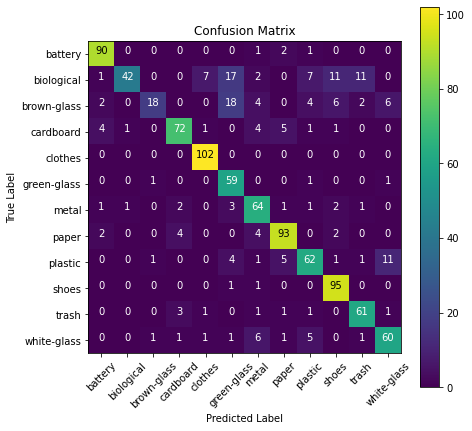

In [ ]:
clf_report(true_value, mobilenetv2_pred)

1/1 [==============================] - 0s 24ms/step


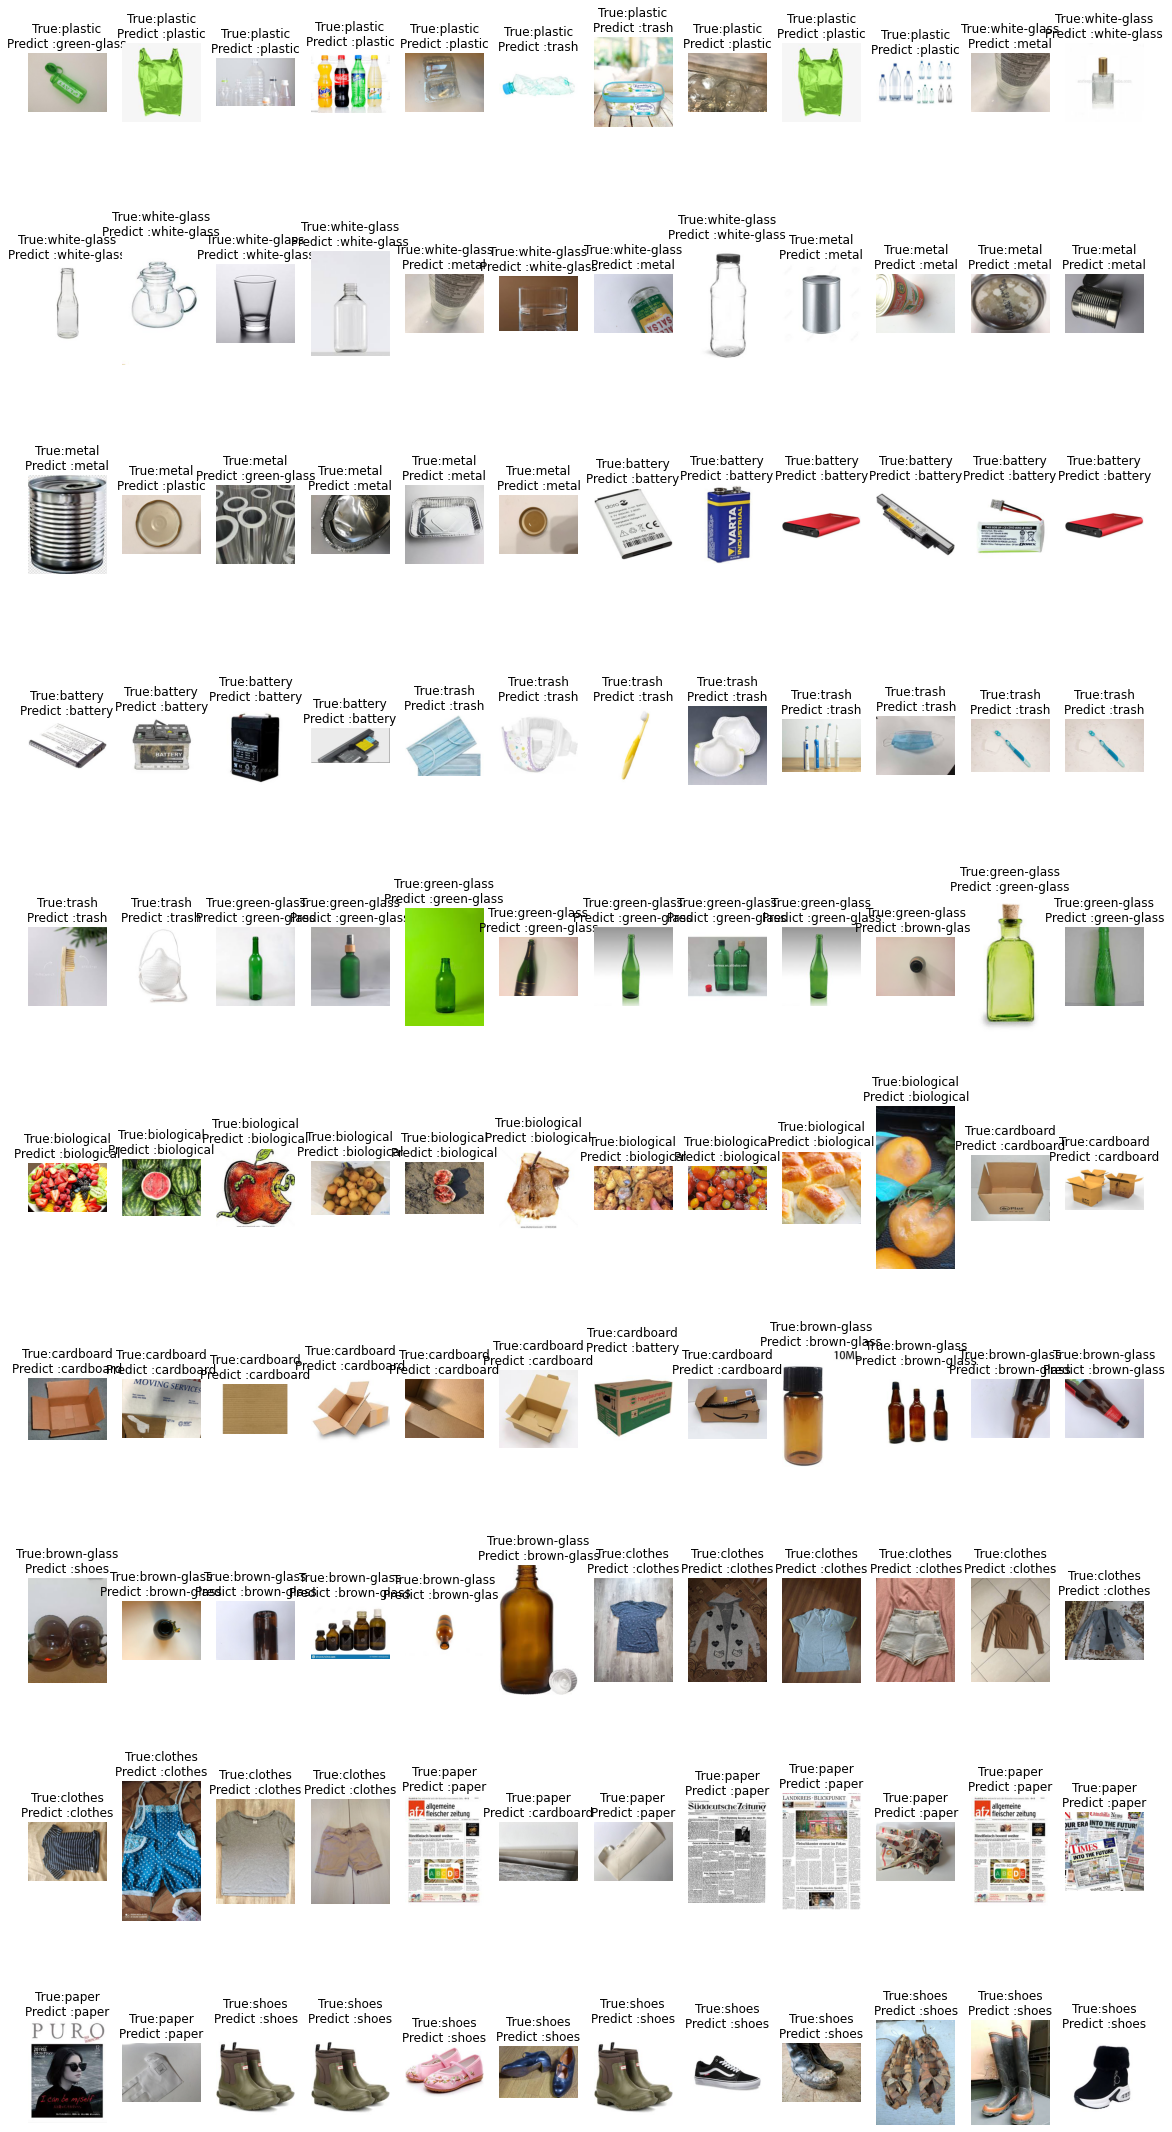

In [ ]:
show_few_images(10, True)

https://www.kaggle.com/code/krishnakumarkk/ensemble-nn-vgg16-resnet50-inceptionv3